# Motivational Example

Let's start our course with a motivational example demonstrating a **simple end-to-end Machine Learning project** from start to finish to show you what a typical data science workflow looks like.

The example is complex on purpose as it introduces topics from almost all upcoming lectures:

- Intro to the environment and tools + Python basics
- Understanding, extracting, sourcing, and processing data
- What is AI/ML & Basic concepts in AI/ML & AI project and workflow
- (Zoo of) ML techniques (algorithms) & Training and improving ML models (ML Pipelines)
- Evaluating, comparing, and selecting ML models

At the end of the course, you will have a deeper understanding and some practical experience with those topics.

## The Problem

We are helping a client to build a mobile app for field researchers that helps them identify and track flower species. With a new app version, the client wants to automate the identification part somewhat.

At first, the client wants to assess the feasibility of this potential feature by building a POC. Luckily, the client can provide a reasonable [dataset](https://archive.ics.uci.edu/ml/datasets/iris) consisting of **four measurements** (sepal length, sepal width, petal length, and petal width) and **identity** (Iris-Setosa, Iris-Versicolour, Iris-Virginica) per sample.

![An example of Iris plant](../../static/images/petal_sepal.jpeg "An example of Iris plant")

> ✏️ The example is inspired by {cite}`rhiever`. Some sections are reduced or extended compare to the original example.

Before diving straight into coding, let's give several thoughts on the problem we are about to work on and ask some follow-up questions.

First, let's identify the use case. We are asked to classify the species (i.e., class) of the flower based on four measurements that we're provided: sepal length, sepal width, petal length, and petal width. The solution should run in a mobile app, so we should consider it.

> ✏️ Researchers collected data. It might be a good indicator of data quality, and we might be able to create a good solution. However, be aware that it could perform poorly if ordinary users use the solution because researchers are probably more precise in taking measurements.

We haven't received any definition of success from the client yet. So, let's ask. **The client told us that he wants to be able to classify 90% of flowers correctly.** Well, we do not know the data yet so let's have a follow-up conversation about the feasibility and reasonability later on.

> ✏️ For education purposes, libraries are imported once they are in use.

## Loading and Checking Data

The next step is to look at the data we're working with. Even curated data sets have errors; finding issues early on can save time later on.

Generally, we're looking to answer the following questions:

- Is there anything wrong with the data?
- Do I need to fix or remove any of the data?

Let's start by downloading the dataset.

> ✏️ To make the exercise reproducible, we use one of the datasets easily accessible with _sklearn_. Check out the [Toy datasets documentation](https://scikit-learn.org/stable/datasets/toy_dataset.html) to find more valuable datasets for initial experiments.

In [1]:
from sklearn.datasets import load_iris

iris_data = load_iris(as_frame=True)
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Let's load the dataset to a pandas data frame with many convenient utilities for the analysis and visualizing several samples.

In [2]:
import pandas as pd

data_df = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
data_df['species'] = pd.Series(iris_data.target).map(lambda i: iris_data.target_names[i])
data_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


The following cell is related to the [exercise](#deal-with-a-noisy-feature) described at the end of the notebook:

In [3]:
import numpy as np

# if you uncomment the following line it will add some noise to data
# data_df['sepal length (cm)'] = data_df['sepal length (cm)'] + np.random.normal(-2.0, 0.25, size=len(data_df))

# if you uncomment the following line it will remove some values
# data_df['petal width (cm)'] = data_df['petal width (cm)'].sample(frac=0.95)

Now is the perfect time to do some checks of our data. In general, we want to make sure that:

- Data is encoded correctly.
- Data falls within the expected range, and use domain knowledge whenever possible to define that expected range.
- Deal with missing data in one way or another: replace it or drop it.

Pandas can easily compute some summary statistics for us:

In [4]:
data_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


By evaluating counts we can see that all values are present in numerical columns. However, we should use code as a record and implement checks as a good practice. For example, check that all data in _sepal length_ are filled with a numerical value.

In [5]:
assert sum(~data_df['sepal length (cm)'].isnull()) == len(data_df)

Let's use some expert domain knowledge (as we asked several researchers) and check that that _sepal lengths_ for _Iris-Versicolour_ should never be below 2.5 cm

In [6]:
assert data_df.loc[data_df['species'] == 'versicolor', 'sepal length (cm)'].min() >= 2.5

Let's bring some visualization capabilities to our notebook to understand our data better. This brings us to a next tip. Plot everything you can about the data at this stage of the analysis, so you can visually confirm everything looks correct.

In [7]:
# this line tells the notebook to show plots inside the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

Next, let's create a **scatterplot** matrix. Scatterplot matrices plot the distribution of each column along the diagonal, and then plot a scatterplot matrix for the combination of each variable. They make for an efficient tool to look for errors in our data.

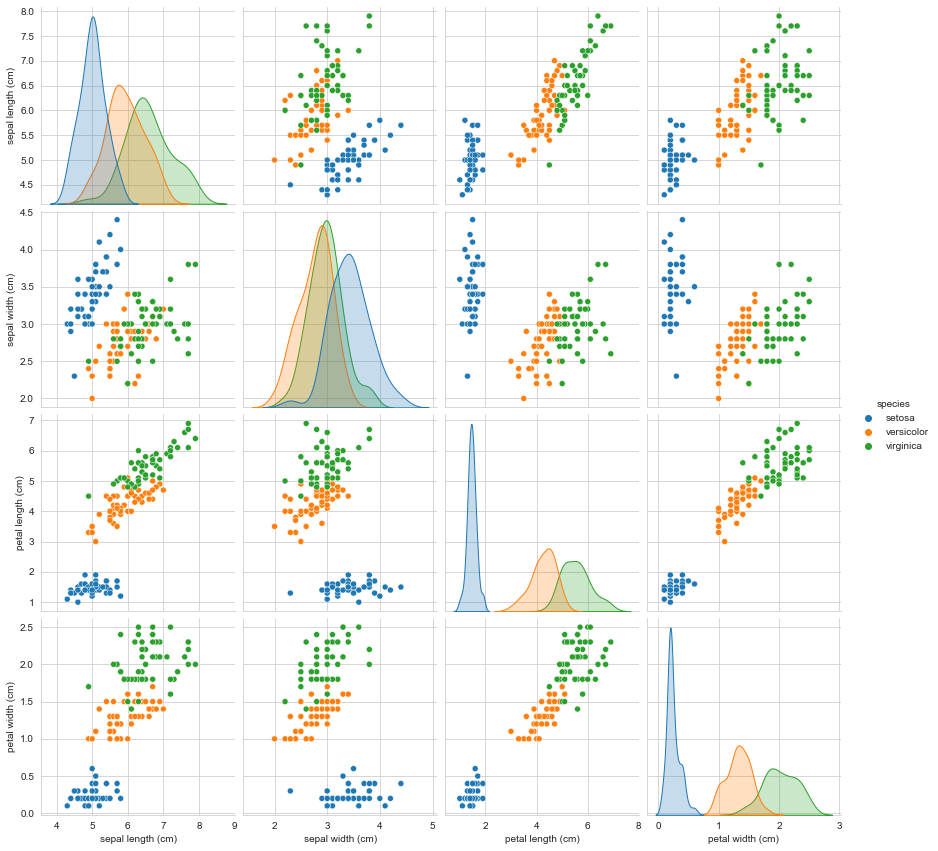

In [8]:
sns.pairplot(data_df, hue='species', height=3);

Last but not least, let's check species distribution in the dataset.

<AxesSubplot:xlabel='species', ylabel='count'>

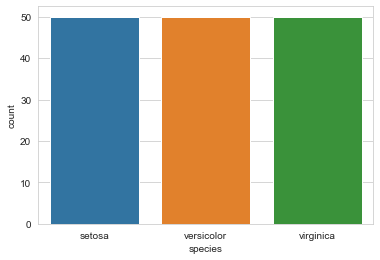

In [9]:
sns.countplot(x="species", data=data_df)

Nice! Each species is equally represented in the dataset. So the accuracy metric can be a good metric after all.

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) aims to analyze data using some visualization techniques. We did some analysis in the previous part, but we will dive deeper in this section. We will look for some trends and patterns in the data.

At the end of this process, we want a better understanding and sense of data to come up with additional questions, adjust how we treat data, and develop an appropriate approach to solve our problem.

> ✏️ Working on a Data Science project is a very iterative process. For example, a good EDA should help us better treat outliers or missing values.

Let's revisit the scatterplot matrix that we used earlier:

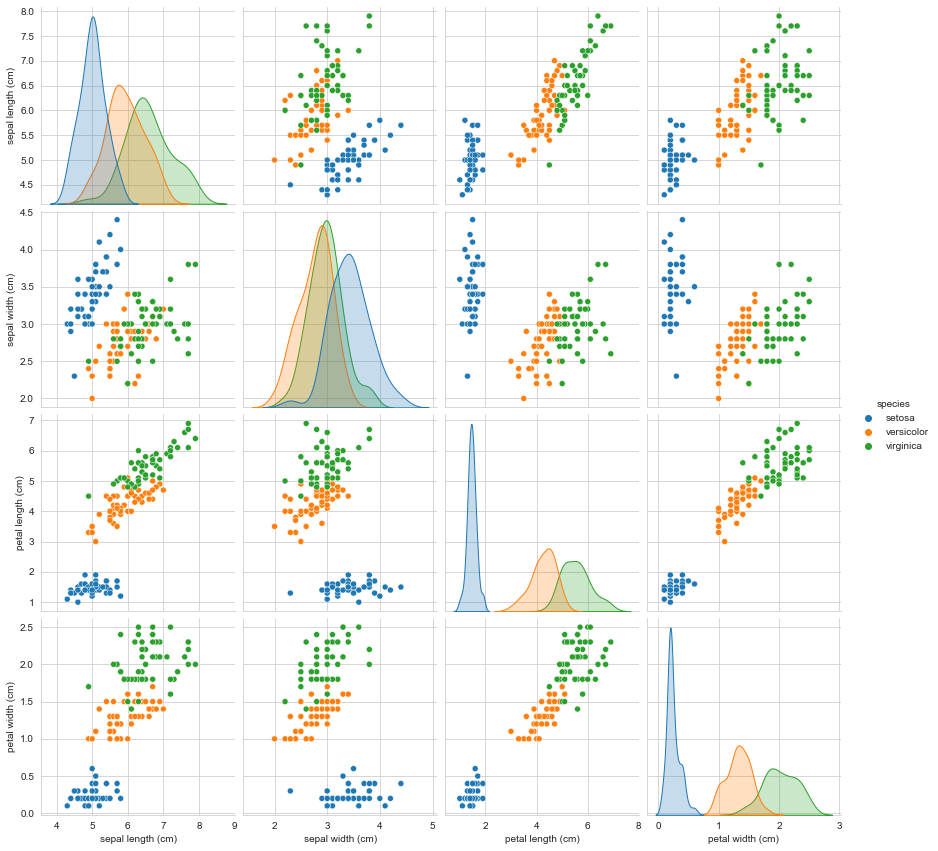

In [10]:
sns.pairplot(data_df, hue='species', height=3);

We can notice the strange distribution of the petal measurements because of the different species. This is excellent news for our classification task since the petal measurements will make it easy to distinguish between _setosa_ and the other Iris types.

Maybe this can be clearer from the following visualizations:

<AxesSubplot:xlabel='petal width (cm)', ylabel='Count'>

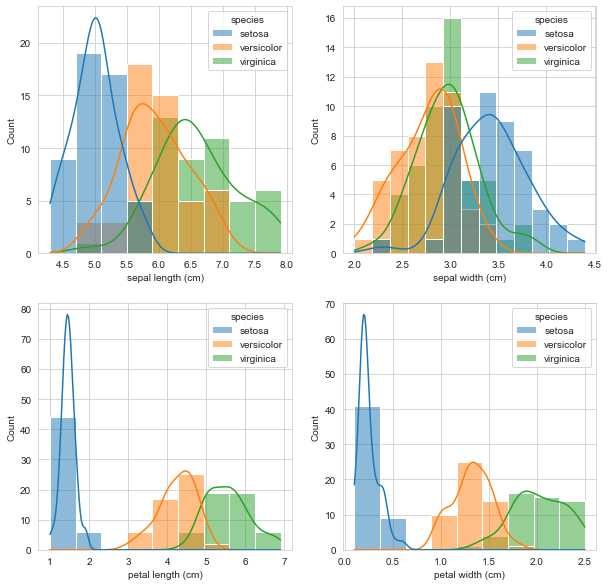

In [11]:
_, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(data=data_df, x="sepal length (cm)", hue="species", ax=axes[0][0], kde=True)
sns.histplot(data=data_df, x="sepal width (cm)", hue="species", ax=axes[0][1], kde=True)
sns.histplot(data=data_df, x="petal length (cm)", hue="species", ax=axes[1][0], kde=True)
sns.histplot(data=data_df, x="petal width (cm)", hue="species", ax=axes[1][1], kde=True)

There are also correlations between petal length and petal width, as well as sepal length and sepal width. We can even measure it:

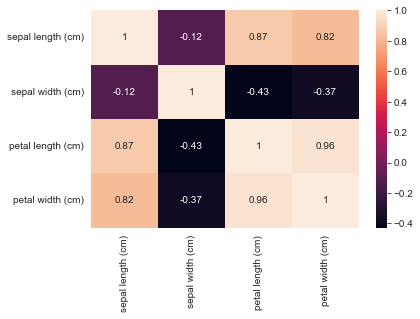

In [12]:
sns.heatmap(data_df.corr(method='pearson'), annot=True);

Let's ask domain experts about this phenomenon. The field biologists assure us that this is to be expected: Longer flower petals also tend to be wider, and the same applies to sepals.

Let's compare the measurement distributions of the classes with box plots.

<AxesSubplot:xlabel='species', ylabel='petal width (cm)'>

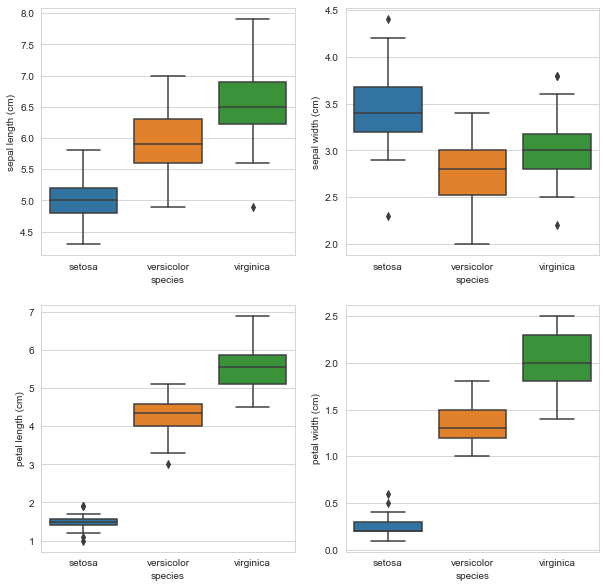

In [13]:
_, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.boxplot(data=data_df, y="sepal length (cm)", x="species", ax=axes[0][0])
sns.boxplot(data=data_df, y="sepal width (cm)", x="species", ax=axes[0][1])
sns.boxplot(data=data_df, y="petal length (cm)", x="species", ax=axes[1][0])
sns.boxplot(data=data_df, y="petal width (cm)", x="species", ax=axes[1][1])

We can also use violin plots. Violin plots contain the same information as box plots, but also scale the box according to the density of the data.

<AxesSubplot:xlabel='species', ylabel='petal width (cm)'>

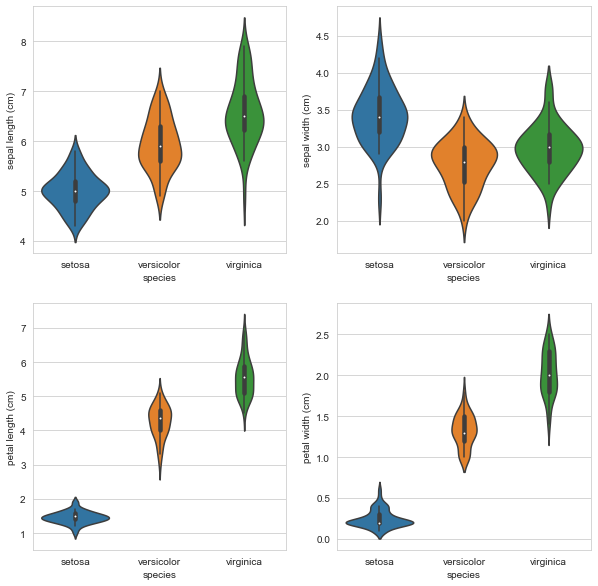

In [14]:
_, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.violinplot(data=data_df, y="sepal length (cm)", x="species", ax=axes[0][0])
sns.violinplot(data=data_df, y="sepal width (cm)", x="species", ax=axes[0][1])
sns.violinplot(data=data_df, y="petal length (cm)", x="species", ax=axes[1][0])
sns.violinplot(data=data_df, y="petal width (cm)", x="species", ax=axes[1][1])

Those are just several insights from the data. We can go on and on. However, we have a good intuition about the problem at this point, so let's build a baseline.

## Solving the problem with Machine Learning

Now, when we better understand our data, let's prototype a solution for the problem. As was mentioned before, we are dealing with a classification problem.

Let's start with the [Decision Tree (DT) algorithm](https://scikit-learn.org/stable/modules/tree.html#), which is easy to interpret and intuitive to understand. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

For example, one of those learned decision rules might be deciding flower classes using petal features. If you remember our EDA, this should not be surprising.

Another lovely property of DT is that we can easily export the model to a different platform by rewriting learned rules.

Let's convert our targets to machine-readable form:

In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder().fit(data_df['species'])
data_df['target'] = encoder.transform(data_df['species'])
data_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,target
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


To assess the ability of our model to classify new flowers and report performance, let's split our dataset into different sets:

- A **training set** is a random subset of the data we use to train our models.
- A **testing set** is a random subset of the data (mutually exclusive from the training set) that we use to validate our models on unforeseen data.

It is, in most cases, essential to have some reasonable hold-out sample of data used for evaluation. In our case, we call it a test set. This dataset is never used in the creation process as it would introduce bias into the evaluation. The metrics we have to report at the end would probably be too optimistic. For example, high accuracy on the training dataset gives us little confidence in the model's performance on unseen data. High accuracy on the testing dataset is a different story.

> ✏️ If we do not say so, we split data in a stratified fashion. It keeps the class proportions the same across all datasets, which is vital for maintaining a representative subset of our data set.

<AxesSubplot:xlabel='class', ylabel='count'>

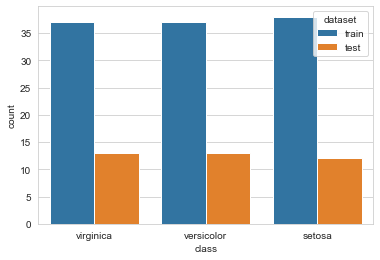

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df[iris_data.feature_names], data_df['target'], test_size=0.25, random_state=42,
    stratify=data_df['target']
)

# plot distributions
labels_df = pd.DataFrame(
    {
        'class': encoder.inverse_transform([*y_train, *y_test]),
        'dataset': ['train' for _ in range(len(y_train))] + ['test' for _ in range(len(y_test))]
    }
)
sns.countplot(x="class", hue="dataset", data=labels_df)

Let's fit our first model on the train set.

In [17]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier(max_depth=2, max_features=2, random_state=42, criterion='log_loss')
decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='log_loss', max_depth=2, max_features=2,
                       random_state=42)

Let's evaluate the performance of the model on the train set.

In [18]:
from sklearn.metrics import classification_report

pd.DataFrame(
    classification_report(
        y_train, decision_tree_classifier.predict(X_train), output_dict=True, target_names=encoder.classes_
    )
).transpose()

,precision,recall,f1-score,support
setosa,1.000000,1.000000,1.000000,38.000000
versicolor,0.923077,0.972973,0.947368,37.000000
virginica,0.971429,0.918919,0.944444,37.000000
accuracy,0.964286,0.964286,0.964286,0.964286
macro avg,0.964835,0.963964,0.963938,112.000000
weighted avg,0.965149,0.964286,0.964260,112.000000


And do the same on the test set:

In [19]:
pd.DataFrame(
    classification_report(
        y_test, decision_tree_classifier.predict(X_test), output_dict=True, target_names=encoder.classes_
    )
).transpose()

,precision,recall,f1-score,support
setosa,1.000000,1.000000,1.000000,12.000000
versicolor,0.923077,0.923077,0.923077,13.000000
virginica,0.923077,0.923077,0.923077,13.000000
accuracy,0.947368,0.947368,0.947368,0.947368
macro avg,0.948718,0.948718,0.948718,38.000000
weighted avg,0.947368,0.947368,0.947368,38.000000


There are many classification metrics. Based on the problem/data, we might care about different ones. What we care about during this exercise is accuracy. And we were able to hit our goal with the baseline on the test set! However, notice the difference between test and train score.

However, there's a catch: Depending on how our training and testing set was sampled. To make it more obvious, we will not split data in a stratified fashion. As you can see, our model can achieve anywhere from 80% to 100% accuracy:

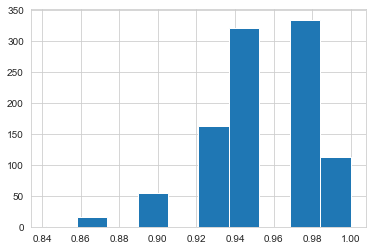

In [20]:
model_accuracies = []

for repetition in range(1000):
    splits = train_test_split(data_df[iris_data.feature_names], data_df['target'], test_size=0.25)
    decision_tree_classifier = DecisionTreeClassifier(max_depth=2, max_features=2, random_state=42, criterion='log_loss')
    decision_tree_classifier.fit(splits[0], splits[2])
    classifier_accuracy = decision_tree_classifier.score(splits[1], splits[3])
    model_accuracies.append(classifier_accuracy)

plt.hist(model_accuracies);

Our model performs quite differently depending on the subset of the data it's trained on. This phenomenon is known as _over-fitting_: The model is learning to classify the training set so well that it doesn't generalize and perform well on data it hasn't seen before. For example, based on the split, it might prefer certain classes.

This problem is the main reason that most data scientists perform _k-fold cross-validation_ on their models: Split the original data set into k subsets, use one of the subsets as the testing set, and the rest of the subsets are used as the training set. This process is then repeated k times such that each subset is used as the testing set exactly once.

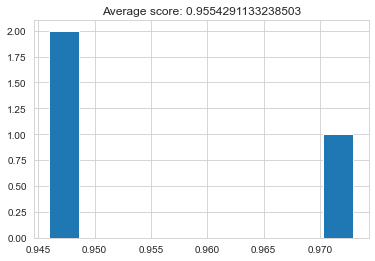

In [21]:
from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier(max_depth=2, max_features=2, random_state=42, criterion='log_loss')
cv_scores = cross_val_score(decision_tree_classifier, X_train, y_train, cv=3)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)));

Now we have better confidence in our classifier's general classification accuracy.

Almost every algorithm comes with various parameters to tune, which can be vitally important to the performance of our classifier. For example, if we severely limit the depth of our decision tree classifier:

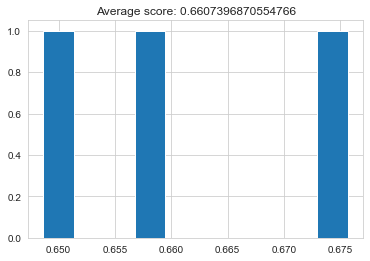

In [22]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1, random_state=42, criterion='log_loss')
cv_scores = cross_val_score(decision_tree_classifier, X_train, y_train, cv=3)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)));

Let's try to find better parameters for our model. We will use a simple technique called Grid Search. The idea behind _Grid Search_ is simple: explore a range of parameters and find the best-performing parameter combination. We will be using cross-validation to evaluate each set of parameters.

In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

decision_tree_classifier = DecisionTreeClassifier(random_state=42, criterion='log_loss')

parameter_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'max_features': [1, 2, 3, 4]
}

cross_validation = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    decision_tree_classifier, param_grid=parameter_grid, cv=cross_validation
)

grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9646752015173069
Best parameters: {'max_depth': 2, 'max_features': 2}


Now let's visualize the grid search to see how the parameters interact:

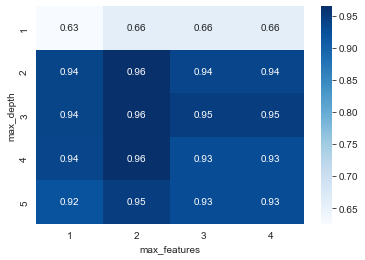

In [24]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (5, 4)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth');

Let's adjust the search with additional parameters:

In [25]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

parameter_grid = {
    'max_depth': [3, 4, 5, 6, None],
    'max_features': [3, 4],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
}

cross_validation = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    decision_tree_classifier, param_grid=parameter_grid, cv=cross_validation
)

grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9554291133238503
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'splitter': 'best'}


Let's train the final model with found parameters on the whole train set:

In [26]:
decision_tree_classifier = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)
decision_tree_classifier.fit(X_train, y_train)

pd.DataFrame(
    classification_report(
        y_test, decision_tree_classifier.predict(X_test), output_dict=True, target_names=encoder.classes_
    )
).transpose()

,precision,recall,f1-score,support
setosa,1.000000,1.000000,1.000000,12.000000
versicolor,1.000000,0.923077,0.960000,13.000000
virginica,0.928571,1.000000,0.962963,13.000000
accuracy,0.973684,0.973684,0.973684,0.973684
macro avg,0.976190,0.974359,0.974321,38.000000
weighted avg,0.975564,0.973684,0.973645,38.000000


Meeting business requirements is one thing. However, it might not be enough for specific problems. We might need a deeper understanding of how the model is working. Let's visualize our model to see how it's making the classifications:

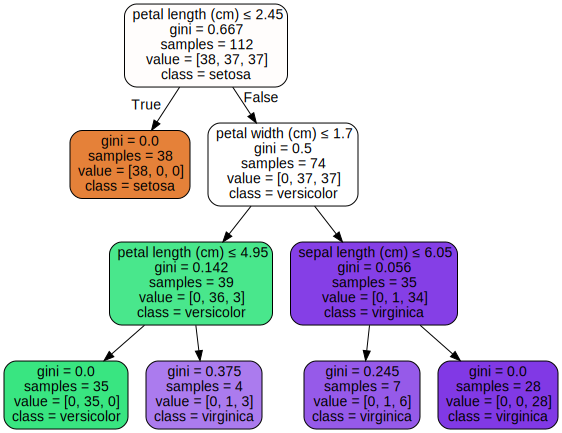

In [27]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(
    decision_tree_classifier, out_file=None, feature_names=iris_data.feature_names,
    class_names=encoder.classes_, filled=True, rounded=True, special_characters=True
)
graph = graphviz.Source(dot_data)
graph

The interpretation is super helpful. We can grab it and consult it with researchers. They know how to classify flowers, at least intuitively, and we can verify the model with them.

## Exercises

### Replace the Decision Tree algorithm with a Random Forest classifier

A common problem decision trees face is that they're prone to over-fitting as they usually classify the training set near-perfectly. Random Forest classifiers work around that limitation by creating a bunch of decision trees (hence "forest") - each trained on random subsets of training samples and features. A combination of several weak classifiers usually leads to better performance.

### Deal with a noisy feature

We have been working with cleaned data in these exercises. One way to make it more challenging is to uncomment one of lines in the [Loading and Checking Data](#loading-and-checking-data).

You need to develop some strategies to handle the issue. The goal is to get creative. You will learn some valuable techniques in the following lecture.

## Resources

```{bibliography}
:filter: docname in docnames
```